In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import collections
%matplotlib inline

In [6]:
df=pd.read_csv("NED26.05.1-D-12.1.0-20160501.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[np.isfinite(df.err)]

In [7]:
df.size

1328280

In [8]:
df=df[df['D (Mpc)']>35]
#df=df[df['D (Mpc)']<500]


In [18]:
meth=[]
ndat=[]
for i in np.unique(df.Method):
    df1=df[df.Method==i]
    meth+=[i]
    ndat+=[df1.shape[0]]
listcut=np.unique(df1['Galaxy ID'])

In [19]:
info=pd.DataFrame({'method':meth,'nrows':ndat})
info.head()

,method,nrows
0,AGN time lag,25
1,BL Lac Luminosity,14
2,Black Hole,14
3,CMD,3
4,Cepheids,4


In [31]:
namelist=list(df1['Galaxy ID']) # list of galaxies
counter=collections.Counter(namelist) # count measurements p. galaxy
# select galaxies with a minimum number of measurements
ulist=[]
nmeas=10
for i in counter.keys():
    if counter[i]>nmeas:
        ulist+=[i]
dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # short dataframe

In [51]:
10**dummy.D

436    347
437    348
438    349
439    350
440    351
441    352
442    353
443    354
444    355
445    356
446    357
447    358
448    359
449    360
450    361
451    362
452    363
453    364
454    365
Name: D, dtype: int64

In [160]:
disterr=0.461*dfs['D (Mpc)']*dfs.err 

In [22]:
i=listcut[10]
i

'2MASX J00511665-2156048'

        errlist[k,0]=em # Number of measurements for each galaxy
        errlist[k,1]=np.mean(booterr) # Percentiles of the combined distance distributions (50, 84, 16):
        errlist[k,2]=(np.percentile(booterr, 84)-np.percentile(booterr, 16))
        errlist[k,3]=dumerr.mean() # average reported error (Delta)
        errlist[k,4]=dummy['D (Mpc)'].mean() # average reported distance (D)
        errlist[k,5]=np.linalg.norm(dumerr/dummy['D (Mpc)'])*(dummy['D (Mpc)'].mean()) # rms error (D)
        errlist[k,6]=np.mean(bootmean)/1e6 # rms error (D)

In [176]:
nbins=1000 # 
em=[] # 0
bootp50=[] #1
bootsig=[] #2
derr=[] #3
dmean=[] #4
rmserr=[] #5
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    em+=[len(dummy)]
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))]
    booterr=np.percentile(tli, 84,axis=0)/1e6-np.percentile(tli, 16,axis=0)/1e6
    #bootmean=np.mean(tli,axis=0) # rms -- is it useful?
    dumerr=disterr[dfilter]
    derr+=[dumerr.mean()] # average reported error (Delta) -- is it useful?
    bootp50+=[np.mean(booterr)]
    bootsig+=[(np.percentile(booterr, 84)-np.percentile(booterr, 16))]
    dmean+=[dummy['D (Mpc)'].mean()] # average reported distance (D)
#    rmserr+=[np.linalg.norm(dumerr/dummy['D (Mpc)'])*dmean] # rms error (D)
#drms=np.mean(bootmean)/1e6 # rms error (D)

In [172]:
len(bootsig)

565

In [159]:
bootmean

array([ 85946271.68911541,  77804310.90120584,  82226671.57987948, ...,
        87784807.50177482,  83617733.45212033,  85059023.21462564])

In [154]:
booterr.mean()

33.77563206355557

In [97]:
tli=np.array(tli) # is this useful? 

In [86]:
len(dummy)

19

In [ ]:
%%time
errlist=np.zeros((len(listcut),7))
k=0
ncutoff=15
nbins=1 # resolution for the generated distributions
nreal=1000
for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if(len(df1[dfilter])>ncutoff): # Select galaxies which have more than n measurements
        
        dummy=df1[dfilter]
        booterr=np.zeros(nreal)
        bootmean=np.zeros(nreal)
        for l in range(nreal):
            data=np.array([])
            for i in dummy.D:
                otherfilter=dummy.D==i
                # generate distance distribution for each distance modulus/ distance modulus error measurement
                AA=10**(np.random.normal(dummy['m-M'][otherfilter],dummy['err'][otherfilter],nbins)/5.+1)
                data=np.hstack((data,AA))            
            booterr[l]=np.percentile(data, 84)/1e6-np.percentile(data, 16)/1e6
            bootmean[l]=np.mean(data)
        dumerr=disterr[dfilter]
#        print np.mean(booterr),(np.percentile(booterr, 84)-np.percentile(booterr, 16)),dumerr.mean(),np.linalg.norm(dumerr/dummy['D (Mpc)'])*(dummy['D (Mpc)'].mean())

        em=len(df1[dfilter])
#        r = gmm.fit(data[:, np.newaxis])
        # Distances in Mpc
#        errlist[k,0]=r.means_[0, 0]/1e6 # Centroid of the GMM-fitted distribution
        errlist[k,0]=em # Number of measurements for each galaxy
#        errlist[k,2]=np.sqrt(r.covars_[0, 0])/1e6 # Variance of the GMM-fitted distribution
        errlist[k,1]=np.mean(booterr) # Percentiles of the combined distance distributions (50, 84, 16):
        errlist[k,2]=(np.percentile(booterr, 84)-np.percentile(booterr, 16))
        errlist[k,3]=dumerr.mean() # average reported error (Delta)
        errlist[k,4]=dummy['D (Mpc)'].mean() # average reported distance (D)
        errlist[k,5]=np.linalg.norm(dumerr/dummy['D (Mpc)'])*(dummy['D (Mpc)'].mean()) # rms error (D)
        errlist[k,6]=np.mean(bootmean)/1e6 # rms error (D)
    k+=1

In [82]:
%%time
nbins=1 # resolution for the generated distributions
nreal=100

for lk in range(100):
    errlist=np.zeros((len(listcho),4))
    k=0
    for i in listcho:
        dfilter=(df1['Galaxy ID']==i)
        glen=dfilter.sum()
        boolar=np.ones(glen).astype(bool)
        boolar[np.random.random_integers(glen)-1]=False
        dummy=df1[dfilter][boolar]
        booterr=np.zeros(nreal)
        bootmean=np.zeros(nreal)
        for l in range(nreal):
            data=np.array([])
            for i in dummy.D:
                otherfilter=(dummy.D==i)
                # generate distance distribution for each distance modulus/ distance modulus error measurement
                AA=10**(np.random.normal(dummy['m-M'][otherfilter],dummy['err'][otherfilter],nbins)/5.+1)
                data=np.hstack((data,AA))            
            booterr[l]=np.percentile(data, 84)/1e6-np.percentile(data, 16)/1e6
            bootmean[l]=np.mean(data)
        dumerr=disterr[dfilter]
    #        print np.mean(booterr),(np.percentile(booterr, 84)-np.percentile(booterr, 16)),dumerr.mean(),np.linalg.norm(dumerr/dummy['D (Mpc)'])*(dummy['D (Mpc)'].mean())

        em=len(df1[dfilter][boolar])
        # Distances in Mpc
        errlist[k,0]=em # Number of measurements for each galaxy
        errlist[k,1]=np.mean(booterr) # Percentiles of the combined distance distributions (50, 84, 16):
        errlist[k,2]=(np.percentile(booterr, 84)-np.percentile(booterr, 16))
        errlist[k,3]=np.mean(bootmean)/1e6 # rms error (D)
        k+=1
    x=errlist[(errlist[:,0]!=0)][:,3]
    y=errlist[(errlist[:,0]!=0)][:,1]
    yerr=errlist[(errlist[:,0]!=0)][:,2]
    ydel=yerr
    # discrepancy test
    # This block uses the emcee MCMC sampler to estimate the posterior probability
    # 1. Guess the starting places for the walkers from a maximum likelihood fit
    nll = lambda *args: -lnlike(*args)
    argum=(x, y,yerr,ydel)
    result = op.minimize(nll, [1,1,1,1,1,1], args=argum)
    m_ml, b_ml,n_ml,f_ml,o_ml,g_ml= result["x"]
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=argum) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    discobs=[]
    discsim=[]
    nrealiz=10000
    for m,b,n,f,o,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
        AAA=samples[np.random.randint(len(samples), size=len(x))]
        y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2 # create a synthetic dataset
        yexp=m*x+b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # calculate expected values from Theta_i
    # Calculate discrepancies using the Freeman-Tukey statistic
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    discobs=np.asarray(discobs)
    discsim=np.asarray(discsim)
    dtest.append((discobs<discsim).sum()*1./len(discobs))

CPU times: user 2h 51min 24s, sys: 1.19 s, total: 2h 51min 25s
Wall time: 2h 51min 40s


In [16]:
%%time
ncutoff=12
listcho=[]
for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if(len(df1[dfilter])>ncutoff): # Select galaxies which have more than n measurements
        listcho.append(i)


CPU times: user 16.1 s, sys: 0 ns, total: 16.1 s
Wall time: 16.1 s


In [ ]:
dtest=[]

In [59]:
# Likelihood
def lnlike(theta, x, y,yerr,ydel):
    m ,b,n,f,o,g = theta
    model = m * x +b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # model equation
    inv_sigma2 = 1.0/((yerr)**2) # weighted by the GMM-fitted sigma
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2))) 
# Priors
def lnprior(theta):
    m, b,n,f,o,g = theta
    if -2 < m < 2 and -20 < b < 20 and  -1 < n < 1 and -10 < f < 10 and -10 < o < 10 and -10 < g < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob(theta, x, y,yerr,ydel):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr,ydel)

In [83]:
dtest

[0.0385,
 0.034500000000000003,
 0.068900000000000003,
 0.0246,
 0.14180000000000001,
 0.11210000000000001,
 0.046699999999999998,
 0.048500000000000001,
 0.053800000000000001,
 0.051200000000000002,
 0.023599999999999999,
 0.074300000000000005,
 0.055199999999999999,
 0.020299999999999999,
 0.069900000000000004,
 0.1106,
 0.030099999999999998,
 0.043200000000000002,
 0.050999999999999997,
 0.059400000000000001,
 0.063,
 0.042799999999999998,
 0.056599999999999998,
 0.041599999999999998,
 0.039300000000000002,
 0.047300000000000002,
 0.058299999999999998,
 0.038800000000000001,
 0.050500000000000003,
 0.051400000000000001,
 0.043900000000000002,
 0.030800000000000001,
 0.016899999999999998,
 0.0252,
 0.050799999999999998,
 0.073300000000000004,
 0.1198,
 0.051499999999999997,
 0.025600000000000001,
 0.0287,
 0.056599999999999998,
 0.066000000000000003,
 0.029100000000000001,
 0.054800000000000001,
 0.085400000000000004,
 0.045499999999999999,
 0.01,
 0.1028,
 0.071400000000000005,
 0.0

In [84]:
this=np.asarray(dtest)

(array([ 16.,  24.,  36.,  15.,   6.,   3.,   5.,   1.,   2.,   2.]),
 array([ 0.0084 ,  0.02499,  0.04158,  0.05817,  0.07476,  0.09135,
         0.10794,  0.12453,  0.14112,  0.15771,  0.1743 ]),
 <a list of 10 Patch objects>)

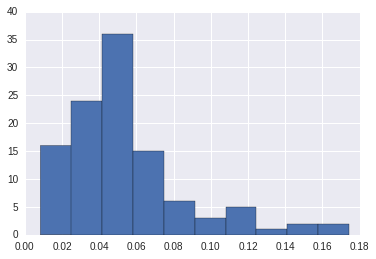

In [85]:
plt.hist(this)

In [81]:
np.unique(errlist[:,0])

array([ 12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.])

In [87]:
(this<0.025).sum()

16

In [88]:
len(this)

110

In [90]:
16./110

0.14545454545454545

In [94]:
-(np.log(this)).sum()

337.33050556056185

In [95]:
 stats.chi2.cdf(337.33, 2*110.)

0.99999940412493504